In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import pandas as pd
import numpy as np
from numpy.random import random, uniform, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import seaborn as sns
sns.set_style('whitegrid') 
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

np.random.seed(42)

with pd.HDFStore('../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks']
sp500_stocks.head()

,name,gics_sector,gics_sub_industry,location,first_added,cik,founded
ticker,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [17]:
with pd.HDFStore('../data/assets.h5') as store:
    prices = store['quandl/wiki/prices'].adj_close
prices.info()
prices.head()

<class 'pandas.core.series.Series'>
MultiIndex: 15389314 entries, (Timestamp('1962-01-02 00:00:00'), 'ARNC') to (Timestamp('2018-03-27 00:00:00'), 'ZUMZ')
Series name: adj_close
Non-Null Count     Dtype  
--------------     -----  
15389313 non-null  float64
dtypes: float64(1)
memory usage: 176.9+ MB


date        ticker
1962-01-02  ARNC      3.448668
            BA        0.871816
            CAT       1.578370
            DD        4.718414
            DIS       0.141259
Name: adj_close, dtype: float64

In [18]:
prices = prices.unstack('ticker')
prices.info()
prices.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 348.6 MB


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
prices = prices.filter(sp500_stocks.index)
prices.info()
prices.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Columns: 449 entries, MMM to ZTS
dtypes: float64(449)
memory usage: 49.0 MB


ticker,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
prices = prices.sample(n=30, axis=1)
prices.info()
prices.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14277 entries, 1962-01-02 to 2018-03-27
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AOS     8457 non-null   float64
 1   GM      1849 non-null   float64
 2   EXR     3427 non-null   float64
 3   MET     4521 non-null   float64
 4   CPB     8252 non-null   float64
 5   FICO    6571 non-null   float64
 6   BK      11326 non-null  float64
 7   AMD     8829 non-null   float64
 8   INTU    6300 non-null   float64
 9   NOC     9137 non-null   float64
 10  CRM     3464 non-null   float64
 11  NWSA    1201 non-null   float64
 12  SNA     8252 non-null   float64
 13  CDNS    7056 non-null   float64
 14  BLK     4650 non-null   float64
 15  LKQ     3643 non-null   float64
 16  CRL     4466 non-null   float64
 17  MRK     12168 non-null  float64
 18  FMC     8252 non-null   float64
 19  SYF     920 non-null    float64
 20  KIM     6634 non-null   float64
 21  NDSN    7056 non-n

ticker,AOS,GM,EXR,MET,CPB,FICO,BK,AMD,INTU,NOC,...,KIM,NDSN,KMI,MOS,WAT,COF,HRL,UPS,STE,NCLH
date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
start = 2008
end = 2017
weekly_returns = prices.loc[f'{start}':f'{end}'].resample('W').last().pct_change().dropna(how='all')
weekly_returns = weekly_returns.dropna(axis=1)
weekly_returns.info()
weekly_returns.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 521 entries, 2008-01-13 to 2017-12-31
Freq: W-SUN
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BG      521 non-null    float64
 1   WM      521 non-null    float64
 2   IVZ     521 non-null    float64
 3   TRV     521 non-null    float64
 4   FICO    521 non-null    float64
 5   NKE     521 non-null    float64
 6   COP     521 non-null    float64
 7   CF      521 non-null    float64
 8   DHI     521 non-null    float64
 9   FITB    521 non-null    float64
 10  LOW     521 non-null    float64
 11  CMI     521 non-null    float64
 12  RL      521 non-null    float64
 13  DLTR    521 non-null    float64
 14  FFIV    521 non-null    float64
 15  WRB     521 non-null    float64
 16  IT      521 non-null    float64
 17  BR      521 non-null    float64
 18  HST     521 non-null    float64
 19  SO      521 non-null    float64
 20  VMC     521 non-null    float64
 21  PPG     

ticker,BG,WM,IVZ,TRV,FICO,NKE,COP,CF,DHI,FITB,...,HST,SO,VMC,PPG,ALL,PWR,AME,ORCL,FOXA,QCOM
date,,,,,,,,,,,,,,,,,,,,,
2008-01-13,0.069008,0.005797,-0.050554,0.001362,-0.064675,-0.016845,-0.029453,0.012044,0.011905,0.024390,...,0.037313,0.027125,-0.033516,-0.051905,0.008027,-0.019279,-0.072156,-0.042215,-0.018490,0.043208
2008-01-20,-0.156397,-0.040026,-0.088986,-0.102410,-0.206739,-0.069193,-0.122230,-0.171137,0.097738,-0.072250,...,-0.065947,-0.050805,-0.037447,-0.018038,-0.058846,-0.167949,-0.070849,0.022749,-0.021978,-0.007248
2008-01-27,0.034549,0.032355,0.038831,-0.016454,0.048230,-0.008850,0.017012,0.115718,0.272053,0.083628,...,0.037227,-0.043720,0.066303,0.015147,0.041065,0.040062,0.122978,-0.060241,0.002140,0.043025
2008-02-03,0.108956,0.070759,0.091715,0.092450,0.087801,0.116250,0.084042,0.042255,0.121841,0.145774,...,0.069307,0.044967,0.099801,0.066508,-0.020416,0.122963,0.017147,0.019724,0.036305,0.055000
2008-02-10,-0.127007,-0.014484,-0.094952,-0.061858,-0.052386,-0.029915,-0.061971,-0.002580,-0.172733,-0.085175,...,-0.027778,-0.041555,-0.094359,-0.041971,-0.057669,-0.090150,-0.043156,-0.072050,0.011850,-0.006635


In [5]:
stocks = weekly_returns.columns
n_obs, n_assets = weekly_returns.shape
n_assets, n_obs

(28, 521)

In [6]:
NUM_PF = 100000 # no of portfolios to simulate
x0 = uniform(0, 1, n_assets)
x0 /= np.sum(np.abs(x0))

periods_per_year = round(weekly_returns.resample('A').size().mean())
periods_per_year

52

In [23]:
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

In [24]:
mean_returns.info()
mean_returns.head()

<class 'pandas.core.series.Series'>
Index: 28 entries, BG to QCOM
Series name: None
Non-Null Count  Dtype  
--------------  -----  
28 non-null     float64
dtypes: float64(1)
memory usage: 1.5+ KB


ticker
BG      0.000404
WM      0.002982
IVZ     0.002601
TRV     0.002845
FICO    0.004427
dtype: float64

In [25]:
cov_matrix.info()
cov_matrix.head()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, BG to QCOM
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BG      28 non-null     float64
 1   WM      28 non-null     float64
 2   IVZ     28 non-null     float64
 3   TRV     28 non-null     float64
 4   FICO    28 non-null     float64
 5   NKE     28 non-null     float64
 6   COP     28 non-null     float64
 7   CF      28 non-null     float64
 8   DHI     28 non-null     float64
 9   FITB    28 non-null     float64
 10  LOW     28 non-null     float64
 11  CMI     28 non-null     float64
 12  RL      28 non-null     float64
 13  DLTR    28 non-null     float64
 14  FFIV    28 non-null     float64
 15  WRB     28 non-null     float64
 16  IT      28 non-null     float64
 17  BR      28 non-null     float64
 18  HST     28 non-null     float64
 19  SO      28 non-null     float64
 20  VMC     28 non-null     float64
 21  PPG     28 non-null     float64
 22  ALL   

ticker,BG,WM,IVZ,TRV,FICO,NKE,COP,CF,DHI,FITB,...,HST,SO,VMC,PPG,ALL,PWR,AME,ORCL,FOXA,QCOM
ticker,,,,,,,,,,,,,,,,,,,,,
BG,0.002369,0.000505,0.001512,0.000471,0.001223,0.000565,0.000940,0.001261,0.001339,0.001665,...,0.001122,0.000237,0.000977,0.000831,0.000955,0.001062,0.000775,0.000613,0.001092,0.000720
WM,0.000505,0.000739,0.000769,0.000415,0.000535,0.000445,0.000527,0.000448,0.000589,0.000812,...,0.000669,0.000236,0.000557,0.000508,0.000647,0.000614,0.000453,0.000466,0.000644,0.000360
IVZ,0.001512,0.000769,0.003261,0.000905,0.001833,0.001273,0.001374,0.001630,0.002648,0.002842,...,0.002260,0.000315,0.002020,0.001441,0.001517,0.001939,0.001327,0.001089,0.001875,0.001126
TRV,0.000471,0.000415,0.000905,0.001061,0.000779,0.000399,0.000539,0.000430,0.000804,0.000740,...,0.000737,0.000276,0.000652,0.000593,0.000706,0.000647,0.000475,0.000406,0.000690,0.000288
FICO,0.001223,0.000535,0.001833,0.000779,0.002577,0.000880,0.000942,0.001089,0.001787,0.002183,...,0.001775,0.000277,0.001533,0.001159,0.001165,0.001478,0.001010,0.000743,0.001348,0.000846


In [26]:
precision_matrix.info()
precision_matrix.head()

<class 'pandas.core.frame.DataFrame'>
Index: 28 entries, BG to QCOM
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BG      28 non-null     float64
 1   WM      28 non-null     float64
 2   IVZ     28 non-null     float64
 3   TRV     28 non-null     float64
 4   FICO    28 non-null     float64
 5   NKE     28 non-null     float64
 6   COP     28 non-null     float64
 7   CF      28 non-null     float64
 8   DHI     28 non-null     float64
 9   FITB    28 non-null     float64
 10  LOW     28 non-null     float64
 11  CMI     28 non-null     float64
 12  RL      28 non-null     float64
 13  DLTR    28 non-null     float64
 14  FFIV    28 non-null     float64
 15  WRB     28 non-null     float64
 16  IT      28 non-null     float64
 17  BR      28 non-null     float64
 18  HST     28 non-null     float64
 19  SO      28 non-null     float64
 20  VMC     28 non-null     float64
 21  PPG     28 non-null     float64
 22  ALL   

ticker,BG,WM,IVZ,TRV,FICO,NKE,COP,CF,DHI,FITB,...,HST,SO,VMC,PPG,ALL,PWR,AME,ORCL,FOXA,QCOM
ticker,,,,,,,,,,,,,,,,,,,,,
BG,765.995462,-30.742588,-104.843075,77.538582,-136.807385,69.021047,-131.653339,-101.798428,-6.339447,-4.720670,...,65.163053,-133.053890,33.127530,-6.696865,-190.635228,-14.022225,7.151676,5.102984,-56.025278,-10.160890
WM,-30.742588,2980.441445,244.249707,-92.637300,253.117414,-188.912616,-157.026023,-77.337925,159.923814,31.741089,...,30.900863,-486.134788,13.056542,-60.956350,-601.799524,-181.199630,18.567052,-289.926996,-55.509987,-52.651358
IVZ,-104.843075,244.249707,1329.625942,-114.700348,6.256310,-249.815037,-142.861732,-58.130029,-75.903650,-46.444321,...,-84.067855,138.302471,-120.403115,65.902234,-256.480246,-102.415588,-27.896423,-143.836721,-46.212404,-125.088528
TRV,77.538582,-92.637300,-114.700348,2175.455319,-189.937491,104.540805,-48.243929,-28.463160,-69.028149,118.379535,...,68.966631,-455.420028,51.819897,-198.454891,-276.899907,-86.454951,61.843543,60.372640,-117.643018,151.477488
FICO,-136.807385,253.117414,6.256310,-189.937491,909.567390,-90.135281,39.292872,13.480188,29.000561,-24.698947,...,-112.079488,-24.226325,-63.802539,-142.558111,-137.098028,-101.276304,-62.261836,19.178128,39.038353,-80.768859


In [8]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())
rf_rate = treasury_10yr_monthly.mean()

In [27]:
treasury_10yr_monthly.info()
treasury_10yr_monthly.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 108 entries, 2008-01-31 to 2016-12-31
Freq: M
Series name: DGS10
Non-Null Count  Dtype  
--------------  -----  
108 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


DATE
2008-01-31    0.000706
2008-02-29    0.000679
2008-03-31    0.000663
2008-04-30    0.000725
2008-05-31    0.000781
Freq: M, Name: DGS10, dtype: float64

In [29]:
rf_rate

0.0004989138176638178

In [31]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.05)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    print(mean_ret.shape, cov.shape, alpha.shape, weights.shape)
    if short:
        weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ weekly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std
    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)
#df = pd.DataFrame(simul_wt)
#df.describe()

(28,) (28, 28) (28,) (100000, 28)


Max Sharpe: 20.70%, 30.35%


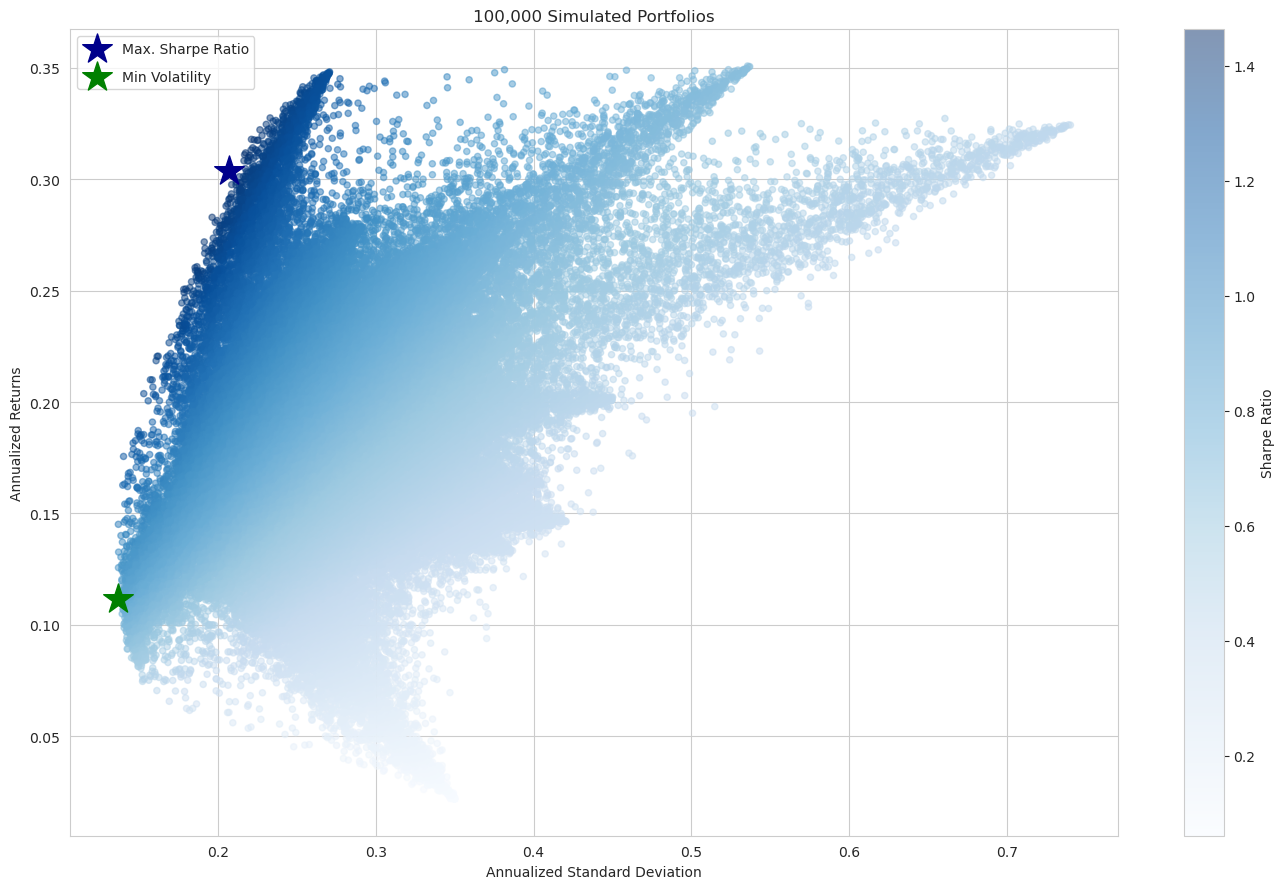

In [10]:
ax = simul_perf.plot.scatter(x=0, y=1, c=2, cmap='Blues',
                             alpha=0.5, figsize=(14, 9), colorbar=True,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
print(f'Max Sharpe: {sd:.2%}, {r:.2%}')
ax.scatter(sd, r, marker='*', color='darkblue', s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

In [11]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

weight_constraint = {'type': 'eq', 'fun': lambda x: np.sum(np.abs(x))-1}

def max_sharpe_ratio(mean_ret, cov, short=False):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

def min_vol_target(mean_ret, cov, target, short=False):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq',
                    'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

def min_vol(mean_ret, cov, short=False):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

def efficient_frontier(mean_ret, cov, ret_range, short=False):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

In [12]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns   Sharpe Ratio
count                  100000.000000       100000.000000  100000.000000
mean                        0.276479            0.185049       0.691284
std                         0.072373            0.050756       0.200384
min                         0.135059            0.022101       0.061739
25%                         0.230128            0.152012       0.553101
50%                         0.262940            0.180041       0.690114
75%                         0.310118            0.214586       0.809172
max                         0.740594            0.351351       1.441518


In [13]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation    0.201371
Annualized Returns               0.290778
Sharpe Ratio                     1.441518
Name: 96751, dtype: float64

In [14]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret    0.282968
sd     0.190183
sr     1.485253
dtype: float64

In [15]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

ret_range = np.linspace(simul_perf.iloc[:, 1].min(), simul_perf.iloc[:, 1].max(), 50)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range, short=True)
eff_pf = pd.Series(dict(zip([p['fun'] for p in eff_pf], ret_range)))

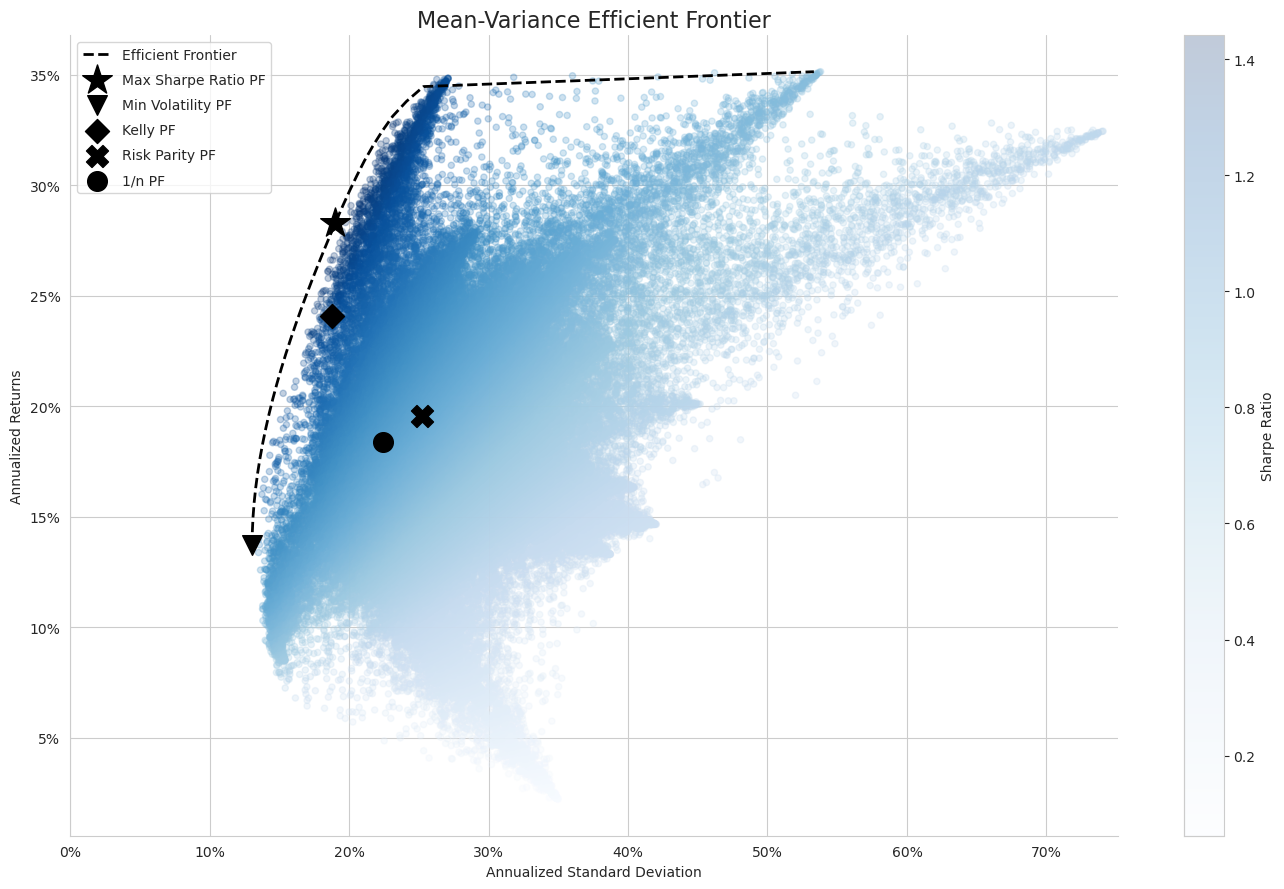

In [16]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax, cmap='Blues',alpha=0.25, 
                        figsize=(14, 9), colorbar=True)

eff_pf[eff_pf.index.min():].plot(linestyle='--', lw=2, ax=ax, c='k',
                                 label='Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='k', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='v', color='k', s=200, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).clip(lower=0).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='D', color='k', s=150, label='Kelly PF')

std = weekly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='X', color='k', s=250, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='o', color='k', s=200, label='1/n PF')


ax.legend(labelspacing=0.8)
ax.set_xlim(0, eff_pf.max()+.4)
ax.set_title('Mean-Variance Efficient Frontier', fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();